In [2]:
# check the working directory
%pwd

'/home/evgenii/solver_package_python-07.10.2023-02.38'

In [ ]:
# compile fortran modules which are used by python scripts

In [1]:
%pwd

'/home/evgenii/solver_package_python-07.10.2023-02.38'

In [4]:
%%sh
sh ./compile_modules.sh

append_needs: unknown need 'int'
append_needs: unknown need 'int'
append_needs: unknown need 'int'
append_needs: unknown need 'int'
append_needs: unknown need 'int'
append_needs: unknown need 'int'
append_needs: unknown need 'int'
append_needs: unknown need 'int'
append_needs: unknown need 'int'
append_needs: unknown need 'int'
append_needs: unknown need 'int'
append_needs: unknown need 'int'
append_needs: unknown need 'int'
append_needs: unknown need 'int'
append_needs: unknown need 'int'
append_needs: unknown need 'int'
append_needs: unknown need 'int'
append_needs: unknown need 'int'
append_needs: unknown need 'int'
append_needs: unknown need 'int'


In [3]:
# import the needed packages
import matplotlib.pyplot as plt
import numpy as np
import tools
import importlib
importlib.reload(tools)

<module 'tools' from '/home/e.polyakov/Notebooks.6/solver_package_python-06.10.2023-02.38/tools.py'>

In [4]:
# top model
j = 40 
top = tools.quantum_top(j)

# Hamiltonian for the free motion of top
p = 1.7
def Hy(t):
    return  p * top.j_y

# kick unitary operator
kick_period = 1.0
k_kick = 4
U_kick = top.kick_z(k_kick / 2 / top.j, 0.1)

/home/e.polyakov/anaconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [5]:
# create bath

import solver
import importlib
importlib.reload(solver)

# chain size
ns = 300
# on-site energies
e = [1.0]*ns
# hoppings between sites
h = [0.2]*(ns-1)

In [6]:
# discretize the bath: apply the lightcone method
bth = solver.bath.from_chain(chain = (e, h), rel_tol = 10**(-5), ring_size = 5, t_max = 500)

In [7]:
# save the bath
bth.save_to_file("bath.1")

In [8]:
# load from file
bth1 = solver.bath.load_from_file("bath.1")

In [9]:
## define the impurity problem

pr = solver.problem()
pr.set_impurity(Hy) # impurity Hamiltonian

# coupling to the bath
def Vs(t):
    return 0.05 * top.j_y

pr.add_bath(bth1, Vs) # bath and coupling 

pr.add_impurity_observable("jx", top.j_x) # what observables to compute
pr.add_impurity_observable("jy", top.j_y) 
pr.add_impurity_observable("jz", top.j_z) 

pr.compute_probs = True # save probabilities of trajectories and calculate entropy
pr.compute_dmatrices = True

# compute the sparse matrix for Fock space truncated on the level of max_num_quanta
pr.construct_model(max_num_quanta = 5) 

# add periodic kick
U_kick_ = tools.kron(U_kick, pr.model.id_e) # multiply by identity of environment
dt = bth1.dt
def kick(t, psi):
    if np.abs(t - np.round(t / kick_period)*kick_period) < dt/2:
        psi[:] = U_kick_ @ psi

pr.set_quench(kick)

In [10]:
# solve the problem
res = pr.solve(cfrom = 1, cto = 1, csize = 1, maxcores = 4, tmax = 100.0, fout = 'results.1')

Wellcome to lightcone impurity solver version 04.10.2023-23.56
Will compute  1  trajectories
on max  4  CPU cores
Will save results into  results.1
Will simulate up to time 100.0
submitting jobs to pool ...
running chunk  1 : m_max =  5 , dim =  20412  ... 
 ... chunk  1  execution time:  322.07206535339355  sec
finished job  1  out of  1

Done!


/home/e.polyakov/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


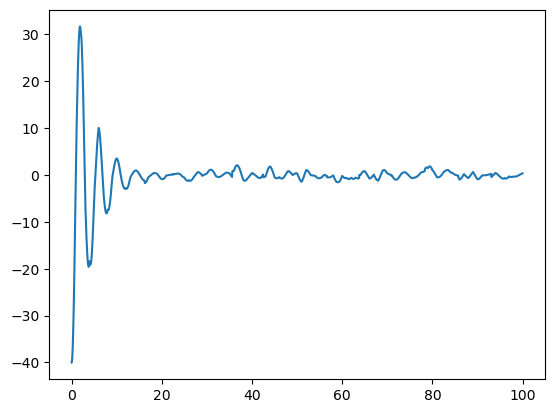

In [11]:
# plot observable
plt.plot(res.t, res['jz'])

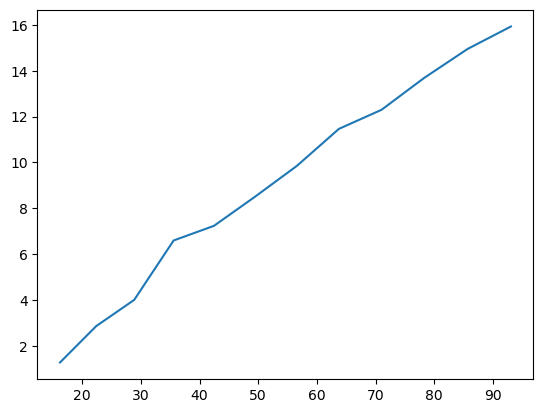

In [12]:
# plot entropy of the entire ensemble of trajectories
plt.plot(res.jump_t, res.jump_S)

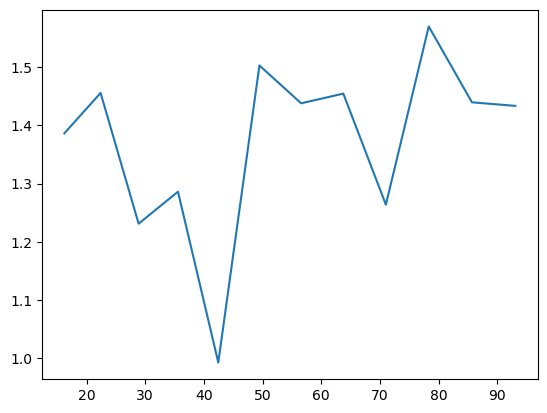

In [13]:
# plot entanglement entropy of each newly decoupled mode
plt.plot(res.jump_t, res.jump_rho_S)